# Reverse time migration example using [Devito](http://www.opesci.org/devito/)

## Equations 

The acoustic wave equation for the square slowness $m$ and a source $q$ is given by:

\begin{cases} 
 &m \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) =q  \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

with the zero initial conditions to guarantee unicity of the solution.

### Solve forward in time 

The wave equation with absorbing boundary conditions can be written as:

\begin{equation}
 \eta \frac{d u(x,t)}{dt} + \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) = q,
\end{equation}

and the adjoint wave equation,

\begin{equation}
-\eta \frac{d u(x,t)}{dt} + \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) = q,
\end{equation}

where $ \eta$  is a damping factor for the absorbing boundary conditions equal to zero inside the physical domain and decreasing inside the absorbing layer from the physical domain to the border.

##  Devito - a finite difference DSL
This two equations are trivial to implement and solve with Devito - the DSL is designed to look like the maths: 

```Python
    wave_equation_forward = m*u.dt2 - u.laplace + damp * u.dt
    stencil_forward = solve(wave_equation,u,forward)[0]

    wave_equation_adjoint= m*u.dt2 - u.laplace - damp * u.dt
    stencil_adjoint = solve(wave_equation,u.backward)[0]
```

The full example can be seen in [the examples folder of Devito](https://github.com/opesci/devito).


## Set up Python environment
For this demo we are parallelizing RTM using [ipyparallel](http://ipyparallel.readthedocs.io/en/latest/api/ipyparallel.html).

```sh
pip install ipyparallel
```

See [the documentation](https://ipython.org/ipython-doc/3/parallel/parallel_process.html) for details on configuring the backend. The quick start for MPI is first,

```sh
ipython profile create --parallel --profile=mpi
```

Edit the file *ipcluster_config.py* and add the lines:
```sh
c.IPClusterEngines.engine_launcher_class = 'MPIEngineSetLauncher'
c.MPI.use = 'mpi4py'
```

Start the cluster with the command:
```sh
ipcluster start -n 12 --profile=mpi
```

In [1]:
from ipyparallel import Client
c = Client(profile='mpi')
dview = c[:]


ImportError: No module named ipyparallel

In [2]:
import sys
import numpy
from examples.acoustic import demo_toolkit
from examples.acoustic.Acoustic_codegen import Acoustic_cg

# Setup figure size
%matplotlib inline

import matplotlib.pyplot as plt
fig_size = [0, 0]
fig_size[0] = 18
fig_size[1] = 13
plt.rcParams["figure.figsize"] = fig_size

## Load synthetic velocity model.

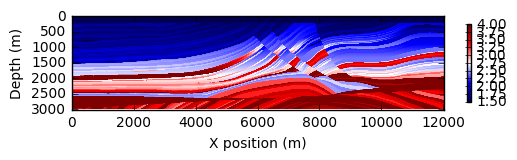

In [3]:
demo = demo_toolkit.marmousi2D()
model = demo.get_true_model()

# Plot true velocity
demo.plot_velocity(model.vp)

## Create "initial guess" by smoothening the synthetic velocity model.

In [ ]:
model0 = demo.get_initial_model()
demo.plot_velocity(model0.vp)

In [ ]:
# Difference plot between true and smoothened velocity.
import matplotlib.pyplot as plt
from matplotlib import cm

fig22 = plt.figure()
l = plt.imshow(numpy.transpose(model0.vp-model.vp), vmin=-.2, vmax=.2, cmap=cm.gray)
plt.colorbar(l, shrink=.25)
plt.show()

## Example of a shot record

In [ ]:
# %%snakeviz
data, rec = demo.get_shot(50)
demo.plot_record(rec)

In [ ]:
# Create acoustic modelling kernel.
Acoustic = Acoustic_cg(model0, data, t_order=2, s_order=10)
# Execute acoustic forward model.
rec0, u, gflopss, oi, timings = Acoustic.Forward(save=False, cse=True)

demo.plot_record(rec0)

In [ ]:
# Plot difference between "observed" and simulated data.
demo.plot_record(rec0 - rec)

# RTM

## Least square objective imaging condition

We will consider here the least square objective. We can write the data fitting problem known as full waveform inversion (FWI) or reverse time migration (RTM) as a least square problem as follows:

\begin{equation}
min_m \Phi(m) := \frac{1}{2} \| P_r A^{-1}(m) q - d\|_2^2
\end{equation}

where $m = \frac{1}{c^2}$ is the square slowness, $A^{-1}(m)$ is the time stepping operator (inverse of the discretized wave equation), $P_r $ is the measurement operator, $q$ is the source and $d$ is the observed data.

For multiple sources it becomes a simple sum over experiments as a separable problem:

\begin{equation}
 min_m \Phi(m) := \sum_{s=1}^{n_{src}} (\frac{1}{2} \| P_{r_s} A^{-1}(m) q_s - d_s\|_2^2)
\end{equation}

We can then obtain the gradient with respect to the square slowness as

\begin{equation}
\nabla_m \Phi(m) = \sum_{s=1}^{n_{src}} ( - (\frac{dA(m)u_s}{dm})^T v_s ) = \sum_{s=1}^{n_{src}} ( \nabla_m \Phi(m)_s )
\end{equation}

where $v_s$ is the solution if the adjoint wave equation $A^{T}(m)  v = P_{r_s}^T (P_{r_s} u_s - d_s)$ and $ u_s$ is the forward wavefield solution of $A(m)u_S = q_s$. For the simple acoustic case the  gradient can be rewritten as 
\begin{equation}
\nabla_m \Phi(m)_s = - \sum_{t=1}^{nt} \frac{d^2u_s(t)}{dt^2} .v_s(t)
\end{equation}

This last equation is the imaging condition. Using it in an iterative method (gradient decent, Quasi-Newton,..) corresponds to FWI where the aim is to invert for the velocity model from an "not so good" initial guess. Once a good estimate of the background velocity model is obtained, this imaging condition is used to obtain an image of the subsurface known as RTM image.

In the following we compute the RTM image on the Marmousi synthetic 2D acoustic model from an artificial background velocity model.

In [ ]:
# %%snakeviz
def grad_shot(i):
    demo = demo_toolkit.marmousi2D()

    model0 = demo.get_initial_model()
    data, rec = demo.get_shot(i)

    Acoustic0 = Acoustic_cg(model0, data, t_order=2, s_order=4)
    rec0, u0, gflopss, oi, timings = Acoustic0.Forward(save=True, cse=True)

    # Return gradient
    return Acoustic0.Gradient(rec0 - rec, u0, cache_blocking=None)

# grad = sum(dview.map(grad_shot, range(4)))
grad = sum(map(grad_shot, range(4)))

In [ ]:
demo.plot_rtm(grad)

In [ ]:
# True shot record
demo.plot_record(rec)

In [ ]:
# Smooth velocity shot record
demo.plot_record(rec0)

In [ ]:
# Data difference (adjoint source for the gradient)
demo.plot_record(rec0-rec)